### Loading The Data

In [ ]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

### Init, helpers, utils, ...

In [22]:
from os.path import isfile, join, exists # to manupulate file paths
from os import listdir, remove, makedirs # get list of all the files in a directory
import shutil

Helper function for seperate dataset into two folders

In [16]:
def seperateData(data_dir):
    for filename in listdir(data_dir):
        if isfile(join(data_dir, filename)):
            tokens = filename.split('.')
            if tokens[-1] == 'jpg':
                image_path = join(data_dir, filename)
                if not exists(join(data_dir, tokens[0])):
                    makedirs(join(data_dir, tokens[0]))
                shutil.copyfile(image_path, join(join(data_dir, tokens[0]), filename))
                remove(image_path)

In [17]:
seperateData(r'...\Pytorch\Cat.Dog\train')

In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### Transforms

In [80]:
train_dir = r'...\Cat.Dog\train'
validation_dir = r'...\Cat.Dog\validation'
test_dir = r'...\Cat.Dog\test1'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.458, 0.456, 0.406), (0.2, 0.2, 0.2))])

train_data = datasets.ImageFolder(train_dir, transform=transform)
validation_data = datasets.ImageFolder(validation_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [81]:
# Helper function
def imshow(image, ax=None, title=None, normalize=True):
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.458, 0.456, 0.406])
        std = np.array([0.2, 0.2, 0.2])
        image = std * image + mean
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


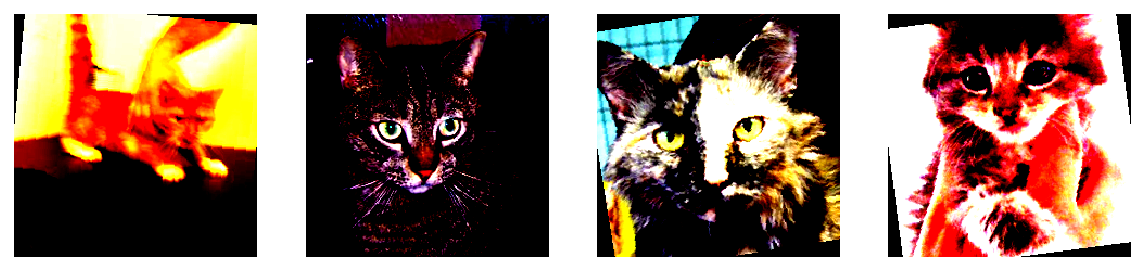

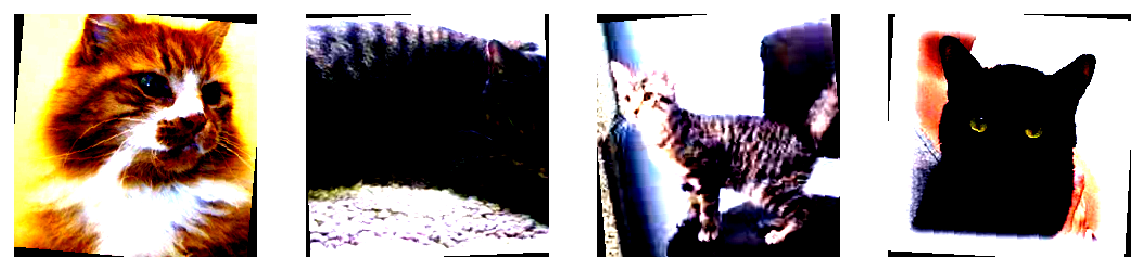

In [82]:
# See how transforms (Augmentation) works
for loader in [trainloader, validloader]:
    data_iter = iter(loader)

    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for ii in range(4):
        ax = axes[ii]
        imshow(images[ii], ax=ax, normalize=False)

### Transfer Learning

In [97]:
from torchvision import models
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
# Helper function - Credit to Stefan Otte

def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)


def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)


def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)


def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [96]:
freeze_all(model.parameters())
assert all_frozen(model.parameters())

In [98]:
# Number of classes is 2
model.fc = nn.Linear(512, 2)

In [100]:
# The new layer model.fc is not frozen one
all_frozen(model.parameters())

False

In [101]:
# Lets use a gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [102]:
def get_model(n_classes=2):
    model = models.resnet18(pretrained=True)
    freeze_all(model.parameters())
    model.fc = nn.Linear(512, n_classes)
    return model


model = get_model().to(device)

### The Loss

In [103]:
criterion = nn.CrossEntropyLoss()

### The optimizer

In [104]:
optimizer = torch.optim.Adam(
            get_trainable(model.parameters()),
            lr=0.001)

### Train the Network
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [ ]:
# number of epoch to train the model
n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    
    model.eval()
    with torch.no_grad():  # IMPORTANT
        for batch_idx, (data, target) in enumerate(validloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
    # Calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(trainloader.sampler)
    
    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tVlidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.367581 	Vlidation Loss: 1.995278
Validation loss decreased (inf --> 1.995278).  Saving model ...
Epoch: 2 	Training Loss: 0.866171 	Vlidation Loss: 1.813379
Validation loss decreased (1.995278 --> 1.813379).  Saving model ...
Epoch: 3 	Training Loss: 0.799353 	Vlidation Loss: 1.714369
Validation loss decreased (1.813379 --> 1.714369).  Saving model ...
Epoch: 4 	Training Loss: 0.766836 	Vlidation Loss: 1.682379
Validation loss decreased (1.714369 --> 1.682379).  Saving model ...
Epoch: 5 	Training Loss: 0.754545 	Vlidation Loss: 1.663583
Validation loss decreased (1.682379 --> 1.663583).  Saving model ...
Epoch: 6 	Training Loss: 0.751054 	Vlidation Loss: 1.642933
Validation loss decreased (1.663583 --> 1.642933).  Saving model ...
Epoch: 7 	Training Loss: 0.749520 	Vlidation Loss: 1.636550
Validation loss decreased (1.642933 --> 1.636550).  Saving model ...
Epoch: 8 	Training Loss: 0.747618 	Vlidation Loss: 1.626233
Validation loss decreased (1.636550 --> 1.